## Cell Classification

## Setting system paths

In [2]:
import sys
if '/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer' not in sys.path:
    sys.path.append('/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer')

## Import Libraries

In [ ]:
import datetime
from geneformer import Classifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
# Generate timestamps for output directory
current_datetime = datetime.datetime.now()
datestamp_long = f"{str(current_datetime.year)[-2:]}{current_datetime.month:02d}{current_datetime.day:02d}{current_datetime.hour:02d}{current_datetime.minute:02d}{current_datetime.second:02d}"
datestamp_short = f"{str(current_datetime.year)[-2:]}{current_datetime.month:02d}{current_datetime.day:02d}"

In [4]:
# Create output directory
output_prefix = "cm_classifier_test"
output_directory = f"/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/{datestamp_long}"
!mkdir $output_directory

/part-vol-2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up training parameters

In [ ]:
# Define output classes
filter_data_dict = {
    "cell_type": ['alpha', 'delta', 'quiescent_stellate', 'gamma', 'macrophage', 'endothelial', 
                  'beta', 'schwann', 'mast', 'acinar', 'ductal', 'activated_stellate']
}

In [ ]:
# Define training arguments
training_arguments = {
    "num_train_epochs": 3,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay": 0.258828,
    "per_device_train_batch_size": 4,
    "seed": 73,
}

In [13]:
# Initialize classifier instance
classifier = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "cell_type", "states": "all"},
    filter_data=filter_data_dict,
    training_args=training_arguments,
    max_ncells=None,
    freeze_layers=2,
    num_crossval_splits=5,
    forward_batch_size=64,
    nproc=8
)

## Preparing data

In [14]:
# Prepare data for training
classifier.prepare_data(
    input_data_file="/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Data/Genecorpus-30M/Pancreas/data/datasets/geneformer/pancreas_scib/pancreas_scib.dataset",
    output_directory=output_directory,
    output_prefix=output_prefix,
    split_id_dict=None
)

Saving the dataset (1/1 shards): 100%|██████████| 1635/1635 [00:00<00:00, 25907.49 examples/s]


## Training the model

In [15]:
# Train the model
all_metrics_train = classifier.validate(
    model_directory="/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer",
    prepared_input_data_file=f"{output_directory}/{output_prefix}_labeled_train.dataset",
    id_class_dict_file=f"{output_directory}/{output_prefix}_id_class_dict.pkl",
    output_directory=output_directory,
    output_prefix=output_prefix,
    split_id_dict=None
)

mkdir: cannot create directory ‘/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/output_directory_cell_class_pancreas/240606010021/240606_geneformer_cellClassifier_cm_classifier_test/’: File exists


completed training!


  0%|          | 0/1 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


****** Validation split: 1/1 ******



/part-vol-2/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/part-vol-2/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will i

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.347900,0.303102,0.930275,0.722727
2,0.178400,0.165518,0.962080,0.815209
3,0.063800,0.105315,0.977370,0.926545


/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/part-vol-2/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/part-vol-2/weaver-core/particle_transformer_quant/notebooks/Fun_Gen/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor

## Model Evaluation

In [18]:
classifier = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "cell_type", "states": "all"},     # change disease?
                forward_batch_size=64,
                nproc=8)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [24]:
# Evaluate the saved model
all_metrics_test = classifier.evaluate_saved_model(
    model_directory=f"{output_directory}/{datestamp_short}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
    id_class_dict_file=f"{output_directory}/{output_prefix}_id_class_dict.pkl",
    test_data_file=f"{output_directory}/{output_prefix}_labeled_test.dataset",
    output_directory=output_directory,
    output_prefix=output_prefix,
)

100%|██████████| 26/26 [00:53<00:00,  2.06s/it]


## Plotting the metrics

<Figure size 1000x1000 with 0 Axes>

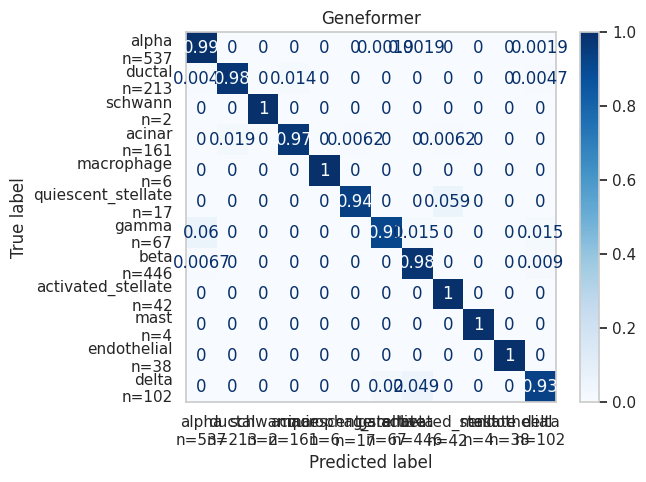

In [25]:
# Plot confusion matrix
classifier.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
    output_directory=output_directory,
    output_prefix=output_prefix,
)


<Figure size 1500x1500 with 0 Axes>

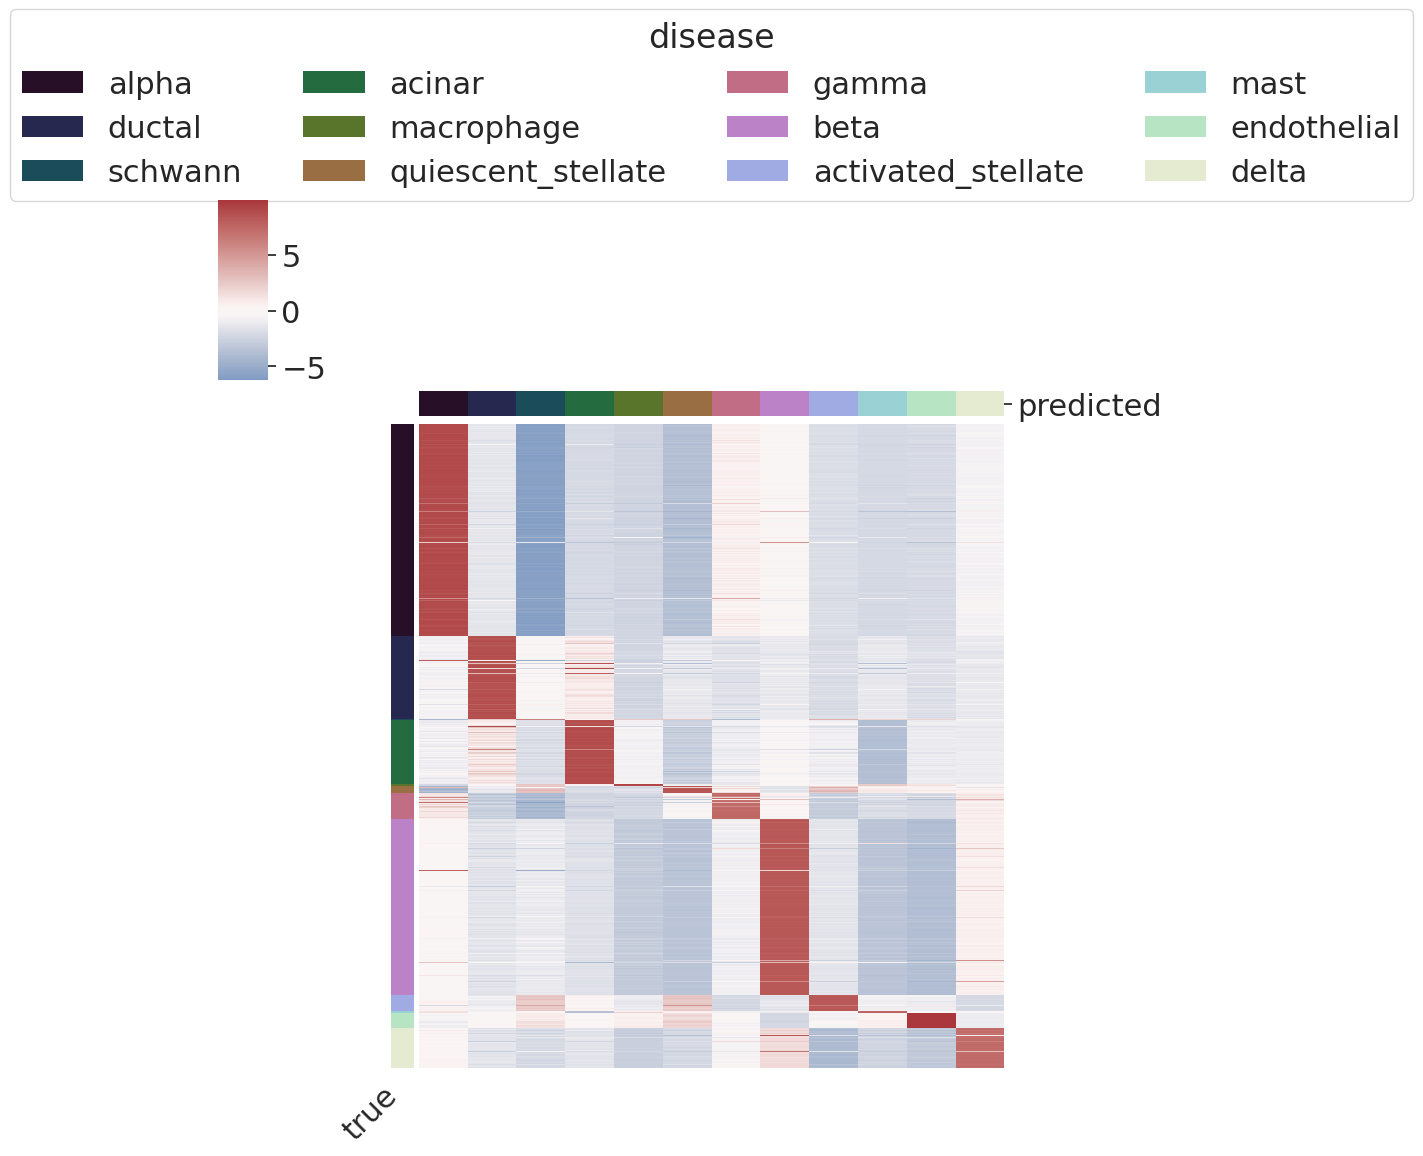

In [26]:
# Plot predictions
classifier.plot_predictions(
    predictions_file=f"{output_directory}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=f"{output_directory}/{output_prefix}_id_class_dict.pkl",
    title="disease",
    output_directory=output_directory,
    output_prefix=output_prefix,
)

In [ ]:
# Define the confusion matrix data
confusion_matrix_data = {
    "alpha": [534, 1, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0],
    "ductal": [0, 208, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1],
    "schwann": [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "acinar": [0, 3, 0, 156, 0, 1, 0, 0, 1, 0, 0, 0],
    "macrophage": [0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    "quiescent_stellate": [0, 0, 0, 0, 0, 16, 0, 0, 1, 0, 0, 0],
    "gamma": [1, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 1],
    "beta": [1, 0, 0, 0, 0, 0, 1, 439, 0, 0, 0, 4],
    "activated_stellate": [0, 0, 0, 0, 0, 1, 0, 0, 42, 0, 0, 0],
    "mast": [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    "endothelial": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0],
    "delta": [0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 95]
}

# Create DataFrame for confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix_data, index=confusion_matrix_data.keys())

In [ ]:
# Function to calculate ROC curves
def calculate_roc(confusion_matrix_df, class_label):
    y_true = []
    y_scores = []
    for idx, row in confusion_matrix_df.iterrows():
        for i in range(len(row)):
            if confusion_matrix_df.columns[i] == class_label:
                y_true.extend([1] * row[i])
                y_scores.extend([1 if idx == class_label else 0] * row[i])
            else:
                y_true.extend([0] * row[i])
                y_scores.extend([1 if idx == class_label else 0] * row[i])
    return roc_curve(y_true, y_scores), auc(*roc_curve(y_true, y_scores)[:2])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

/tmp/ipykernel_12004/4207203142.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.extend([1] * row[i])
/tmp/ipykernel_12004/4207203142.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_scores.extend([1 if idx == class_label else 0] * row[i])
/tmp/ipykernel_12004/4207203142.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.extend([0] * row[i])
/tmp/ipykernel_12004/4207203142.py:35: FutureWarning: Series.__get

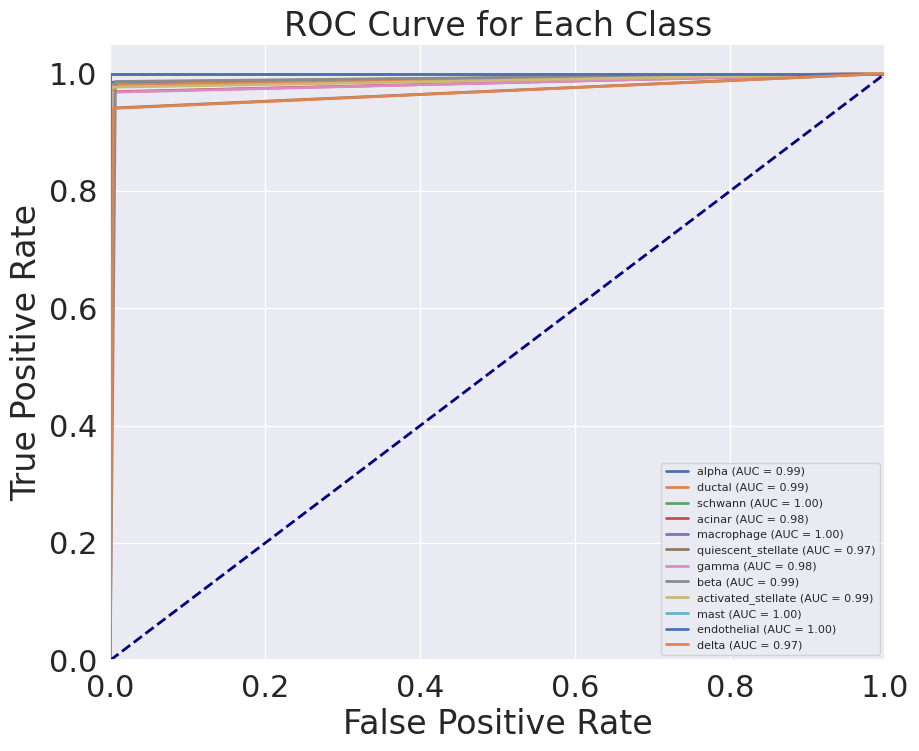

In [35]:
for class_label in confusion_matrix_df.columns:
    (fpr, tpr, _), roc_auc = calculate_roc(confusion_matrix_df, class_label)
    plt.plot(fpr, tpr, lw=2, label=f'{class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right', fontsize=8)

plt.show()

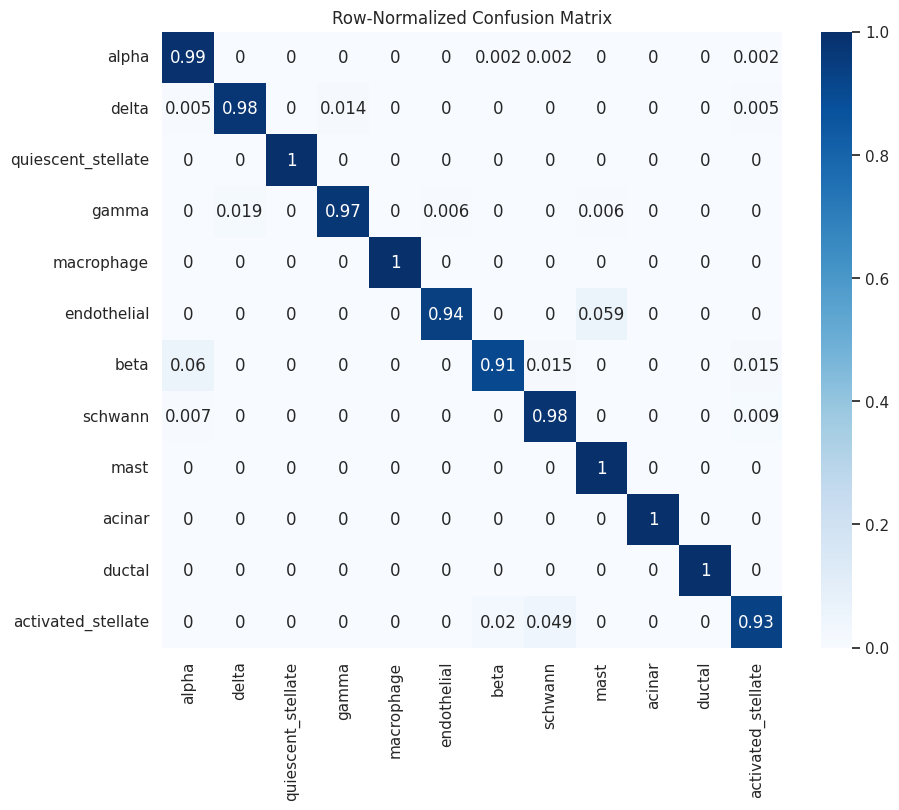

In [52]:
# Calculate and plot row-normalized confusion matrix
confusion_matrix_np = np.array(confusion_matrix_df.round(2))
row_sums = confusion_matrix_np.sum(axis=1, keepdims=True)
row_normalized = confusion_matrix_np / row_sums

# Plot row-normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(np.round(row_normalized, 3), annot=True, cmap='Blues', xticklabels=confusion_matrix_df.columns, yticklabels=confusion_matrix_df.index, ax=ax)
ax.set_title('Row-Normalized Confusion Matrix')

plt.show()